In [1]:
#This cell is used to download dataset from kaggle at run time
import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'garbage-classification:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F81794%2F189983%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240929%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240929T131139Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D9016e825ca0498f359b4aefe93eaa04a3496b547170e91b6f7c43474693137e7f216e0d684b5aef2b6c25f6ec6ddb3dd6ee88563e2c12514b9a8c3167ec73c043e688115cab1d8b164161518ecf318abe5b74d7e66373463ab675603d8e386d46be759efbd18fbc66d668b7003852a2dd9f68dcc3be6f1063db71af3e6d6d5fafd916ed99dc024ff14b949c0e563e541d4fbe623b9a31ddad05619c7333be09935882e56daec8fdfeb6498acae6cbeaf2189bc25f3f2acf16d281616ed53588ffd6b271bb09e0a964e1c955b672bb5db7df66405da73103c3045470556bd15350f9d4b983fd46c5f125c88b18db0f383218c2c458e1ddb782d881cdec38eeb8c,d/mostafaabla/garbage-classification:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F1115942%2F1874598%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240929%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240929T131139Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D2938c0f35a65548e299935b10d8c3da8d73cbcfff7f0ff666b1252a7d02f8bb5b7d08b79b369204255173c14b4e60870940462afb707db2dc00c0360d193e0066e5aecece7d2d99f03051a16fd5377046c4f3019fa4a845852588c7771e9eeca9fad5b6ffc924befe6c433685e6162acd7558b0697141a2338a9e27287c680ebd5ffbc0755bbe03801d059a803cf7bc31be8735ab8f3f181714cbf145bbaca826815670f5f41a4d36902556a5dfe83ae6a0bf3d78f4d1c50c2d94599ebbee92feacdab70e5ead1a24c4f94939300653e4c0a0e9c0873238211549b874341b9ca6de243ae7f2e2bcd9d06ce4357fb67ed7d8fc2a4eebb9e8967e90e22e9e898ad'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 85969666 bytes downloaded
Downloaded and uncompressed: garbage-classification
[==================================================] 250641573 bytes downloaded
Downloaded and uncompressed: d/mostafaabla/garbage-classification
Data source import complete.


In [2]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
import random
import shutil             # to copy images to another directory
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report , confusion_matrix

from tqdm import tqdm
from keras.layers import Conv2D, MaxPooling2D , BatchNormalization ,Dropout ,Flatten , Dense , Input , Rescaling , Resizing
from keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.applications import MobileNetV2

import warnings

with warnings.catch_warnings():
    warnings.simplefilter("ignore")

plt.style.use('ggplot')

In [3]:
#Load the data
dataDirList = ['/kaggle/input/garbage-classification/Garbage classification/Garbage classification/' ,
              '/kaggle/input/d/mostafaabla/garbage-classification/garbage_classification/']

selectedClasses = ['metal', 'glass', 'paper', 'trash', 'cardboard', 'plastic' ,'white-glass']

In [4]:
imgPaths = []
labels = []
for dataDir in dataDirList:
    for className in os.listdir(dataDir):
        if className in selectedClasses :
            classPath = os.path.join(dataDir,className)
            for img in os.listdir(classPath):
                imgPath = os.path.join(classPath,img)
                imgPaths.append(imgPath)
                if className == 'white-glass':
                    className = 'glass'
                labels.append(className)

# Convert the 2 lists to dataframe
df = pd.DataFrame({
    'imgPath':imgPaths,
    'label':labels
})

df = df.sample(frac=1).reset_index(drop=True)            # Shuffle data

df

imgPath      label
0     /kaggle/input/garbage-classification/Garbage c...      glass
1     /kaggle/input/garbage-classification/Garbage c...    plastic
2     /kaggle/input/d/mostafaabla/garbage-classifica...      paper
3     /kaggle/input/d/mostafaabla/garbage-classifica...      paper
4     /kaggle/input/garbage-classification/Garbage c...    plastic
...                                                 ...        ...
7569  /kaggle/input/d/mostafaabla/garbage-classifica...      metal
7570  /kaggle/input/d/mostafaabla/garbage-classifica...      trash
7571  /kaggle/input/d/mostafaabla/garbage-classifica...  cardboard
7572  /kaggle/input/d/mostafaabla/garbage-classifica...      glass
7573  /kaggle/input/garbage-classification/Garbage c...      paper

[7574 rows x 2 columns]

# <a id="2"></a>
<div style="padding:10px;
            color:white;
            margin:5;
            font-size:170%;
            text-align:left;
            display:fill;
            border-radius:15px;
            background-color:#294B8E;
            overflow:hidden;
            font-weight:700">2. Spliting</div>

In [5]:
def DataFrameSpliting(df , ratio , classesList):

    trainDf = pd.DataFrame(columns = ['imgPath','label'])
    testDf = pd.DataFrame(columns = ['imgPath','label'])
    for c in classesList :
        tempDf = df[df['label'] == c]
        lastIndex = int(len(tempDf) * ratio)
        trainClassDf = tempDf[:lastIndex]
        testClassDf = tempDf[lastIndex:]
        trainDf = pd.concat([trainDf , trainClassDf] , axis=0)
        testDf = pd.concat([testDf , testClassDf] , axis=0)

    return trainDf.sample(frac=1).reset_index(drop=True) , testDf.sample(frac=1).reset_index(drop=True)  # shuffling and reseting index

In [6]:
classList = list(df['label'].unique())
trainDf , testDf = DataFrameSpliting(df , 0.85 , classList) #Splitting dataset with 85% for training and 15% for testing

In [7]:
trainDf

imgPath      label
0     /kaggle/input/d/mostafaabla/garbage-classifica...      trash
1     /kaggle/input/garbage-classification/Garbage c...  cardboard
2     /kaggle/input/garbage-classification/Garbage c...  cardboard
3     /kaggle/input/d/mostafaabla/garbage-classifica...  cardboard
4     /kaggle/input/d/mostafaabla/garbage-classifica...  cardboard
...                                                 ...        ...
6429  /kaggle/input/d/mostafaabla/garbage-classifica...  cardboard
6430  /kaggle/input/d/mostafaabla/garbage-classifica...      paper
6431  /kaggle/input/d/mostafaabla/garbage-classifica...      paper
6432  /kaggle/input/garbage-classification/Garbage c...      glass
6433  /kaggle/input/d/mostafaabla/garbage-classifica...      metal

[6434 rows x 2 columns]

In [8]:
trainDf['label'].value_counts()

label
paper        1397
plastic      1144
cardboard    1099
glass        1084
metal        1002
trash         708
Name: count, dtype: int64

In [9]:
testDf

imgPath      label
0     /kaggle/input/d/mostafaabla/garbage-classifica...    plastic
1     /kaggle/input/d/mostafaabla/garbage-classifica...  cardboard
2     /kaggle/input/d/mostafaabla/garbage-classifica...      paper
3     /kaggle/input/garbage-classification/Garbage c...    plastic
4     /kaggle/input/d/mostafaabla/garbage-classifica...      paper
...                                                 ...        ...
1135  /kaggle/input/garbage-classification/Garbage c...      metal
1136  /kaggle/input/garbage-classification/Garbage c...      glass
1137  /kaggle/input/garbage-classification/Garbage c...      glass
1138  /kaggle/input/d/mostafaabla/garbage-classifica...  cardboard
1139  /kaggle/input/garbage-classification/Garbage c...      glass

[1140 rows x 2 columns]

In [10]:
testDf['label'].value_counts()

label
paper        247
plastic      203
cardboard    195
glass        192
metal        177
trash        126
Name: count, dtype: int64

Data Explorations

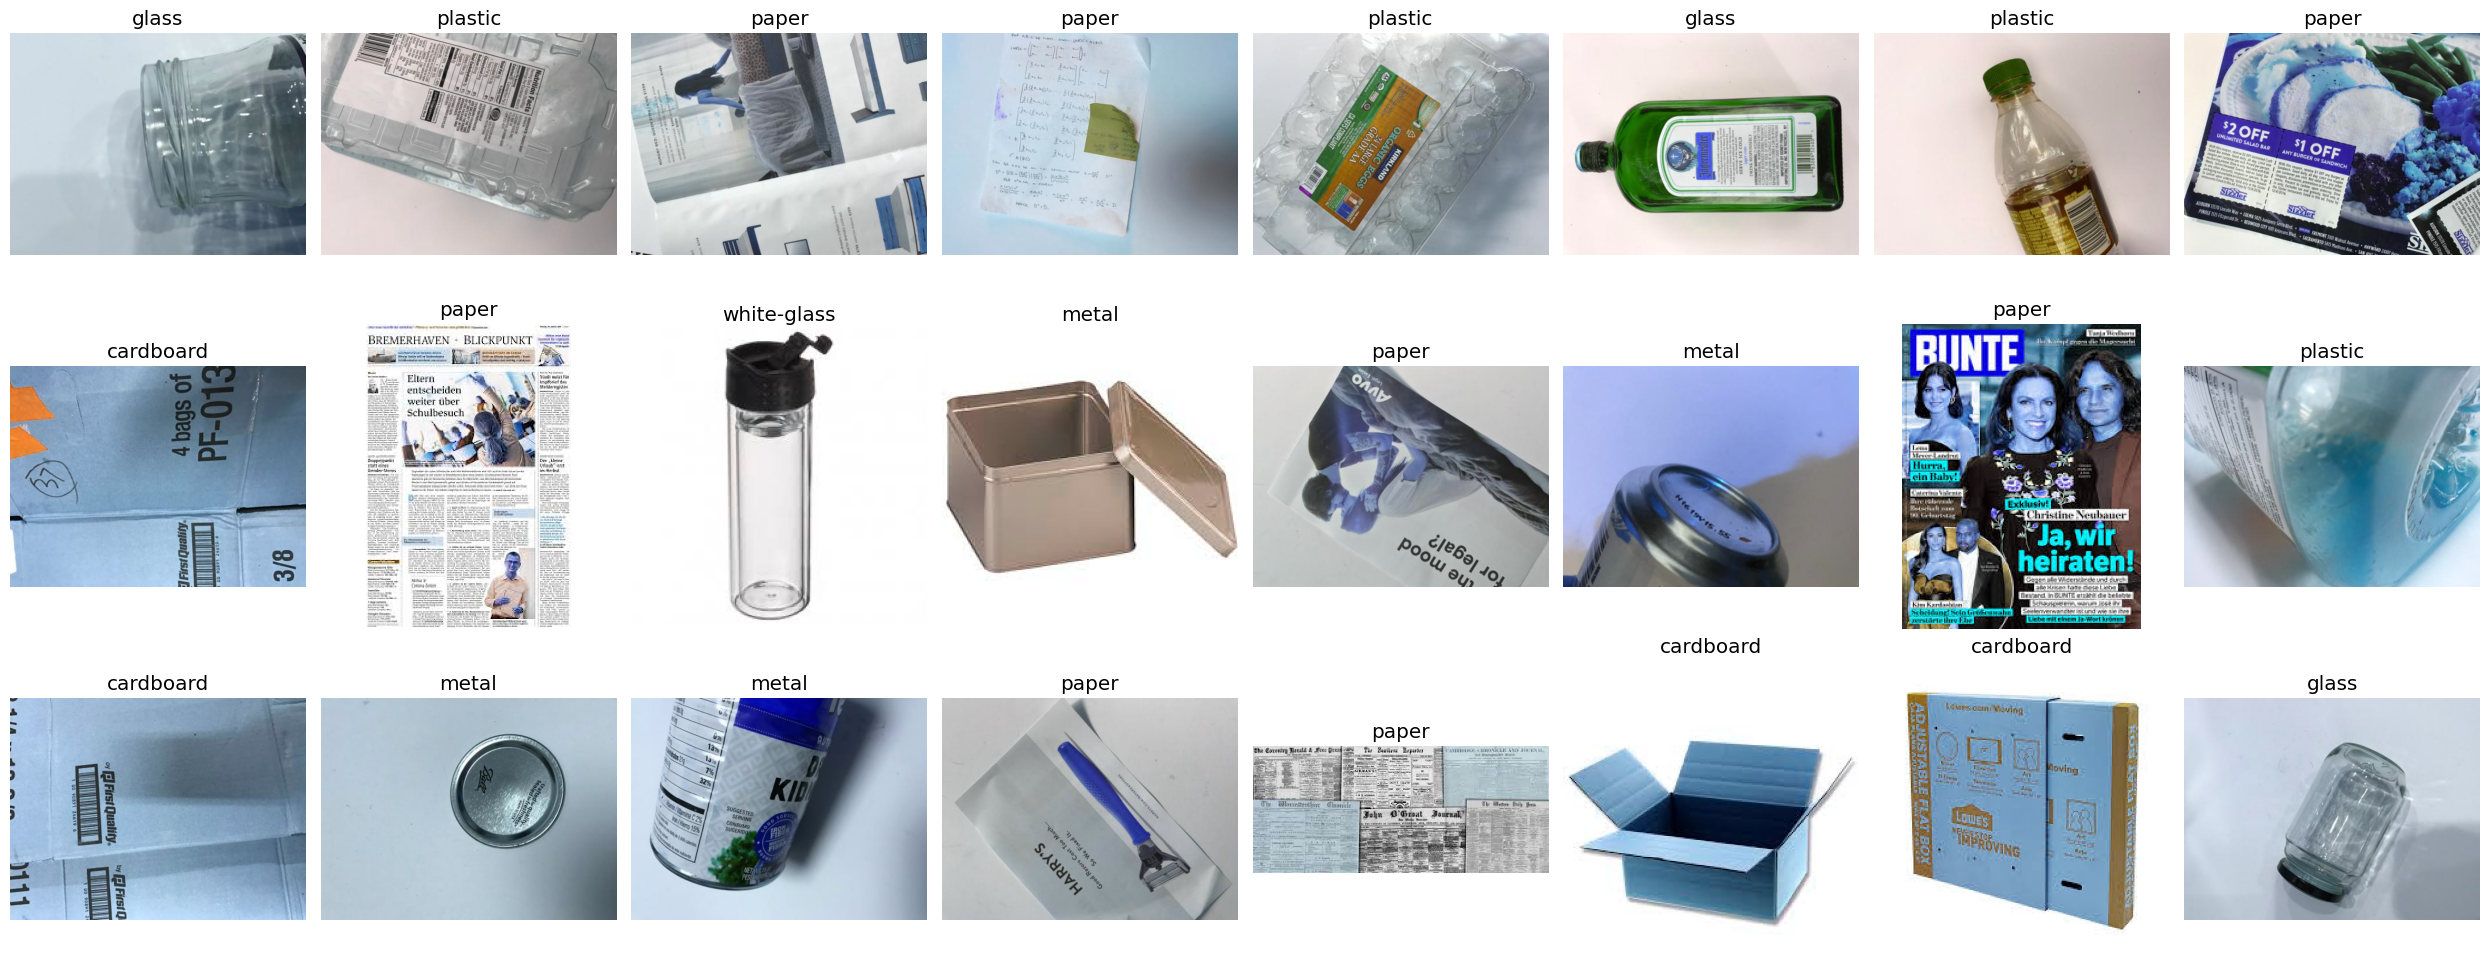

In [11]:
imgPaths = df['imgPath']
fig, axs = plt.subplots(3, 8, figsize=(25, 10))

axs = axs.flatten()

for ax,imgPath in zip(axs , imgPaths):
    label = str(imgPath).split('/')[-2]    # extract label of an imgae from a path
    img = cv2.imread(imgPath)
    ax.imshow(img)
    ax.set_title(label)
    ax.axis('off')

plt.tight_layout()
plt.show()

Data Augmentation

In [12]:
datagenTrain = ImageDataGenerator(
            rescale=1./255,
            zoom_range=(1.0, 1.2),   # zoom input picture
            horizontal_flip=True,
            vertical_flip=True,
            rotation_range=45,
)

In [13]:
IMG_SIZE = (224,224)    #image input size

trainGenerator = datagenTrain.flow_from_dataframe(
    trainDf ,
    x_col='imgPath',
    y_col='label',
    target_size=IMG_SIZE,
    batch_size=64 ,                    # Generate 64 image from the datagenTrain (flipped , rotated , zoomed , ....)  at once
    class_mode='categorical'
)


datagenTest = ImageDataGenerator( rescale=1./255 )

testGenerator = datagenTest.flow_from_dataframe(
    testDf ,
    x_col='imgPath',
    y_col='label',
    target_size=IMG_SIZE,
    batch_size=8 ,
    class_mode='categorical',
    shuffle=False
)


print(f"Training set size: {trainGenerator.samples}")
print(f"Testing set size: {testGenerator.samples}")

Found 6434 validated image filenames belonging to 6 classes.
Found 1140 validated image filenames belonging to 6 classes.
Training set size: 6434
Testing set size: 1140


# <a id="5"></a>
<div style="padding:10px;
            color:white;
            margin:5;
            font-size:170%;
            text-align:left;
            display:fill;
            border-radius:15px;
            background-color:#294B8E;
            overflow:hidden;
            font-weight:700">5. Modeling </div>

In [14]:
with tf.device('/GPU:0'):          # to use GPU
    Model = Sequential([

        MobileNetV2(weights='imagenet', include_top=False, input_shape=(224,224,3)),

        Flatten(),                                     # because we ignore the flatten and dense layers when include_top = False

        Dense(64,activation='relu'),

        BatchNormalization(),

        Dropout(0.08),

        Dense(6 ,activation='softmax')
    ])

In [15]:
preTrainedModel = Model.layers[0]
for layer in preTrainedModel.layers[:-4]:           # freez all layers except the first and last 3 layers, we will make them trainable (weghts changes with training)
    layer.trainable = False

In [16]:
Model.compile(optimizer='adam',loss='categorical_crossentropy' ,metrics=['accuracy'])

In [17]:
#Training The Model
training_history = Model.fit(trainGenerator,
                    validation_data = testGenerator,
                    epochs=50,
                    verbose=1,
                    callbacks=[tf.keras.callbacks.EarlyStopping(
                                       patience=4,
                                       monitor='val_accuracy',
                                       restore_best_weights=True)])

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


101/101 ━━━━━━━━━━━━━━━━━━━━ 117s 937ms/step - accuracy: 0.7134 - loss: 0.8443 - val_accuracy: 0.7842 - val_loss: 0.6549
Epoch 2/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 116s 787ms/step - accuracy: 0.8780 - loss: 0.3610 - val_accuracy: 0.8614 - val_loss: 0.4135
Epoch 3/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 85s 791ms/step - accuracy: 0.9040 - loss: 0.2652 - val_accuracy: 0.8868 - val_loss: 0.3343
Epoch 4/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 98s 904ms/step - accuracy: 0.9264 - loss: 0.2068 - val_accuracy: 0.8939 - val_loss: 0.3156
Epoch 5/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 133s 810ms/step - accuracy: 0.9331 - loss: 0.1965 - val_accuracy: 0.9070 - val_loss: 0.2614
Epoch 6/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 142s 822ms/step - accuracy: 0.9537 - loss: 0.1436 - val_accuracy: 0.9070 - val_loss: 0.2922
Epoch 7/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 140s 802ms/step - accuracy: 0.9555 - loss: 0.1277 - val_accuracy: 0.9167 - val_loss: 0.2586
Epoch 8/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 140s 795ms/step - accuracy: 0.9602 - loss: 0.1169

In [18]:
Model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 62720)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │       4,014,144 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 6)                   │             390 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 15,127,700 (57.71 MB)

 Trainable params: 4,427,462 (16.89 MB)

 Non-trainable params: 1,845,312 (7.04 MB)

 Optimizer params: 8,854,926 (33.78 MB)

In [31]:
#Saving Model for use in WebApp
Model.save('garbage_classification_model.keras')

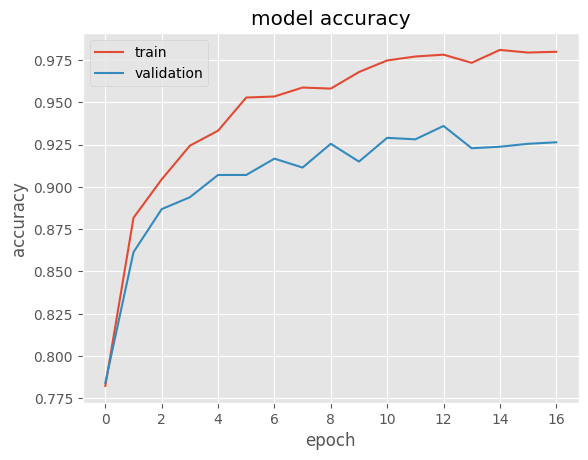

In [20]:
plt.plot(training_history.history['accuracy'])
plt.plot(training_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [21]:
#Saving Training History in json format
import json
with open('training_history.json','w') as f:
  json.dump(training_history.history,f)

In [22]:
predictions = Model.predict(testGenerator)

143/143 ━━━━━━━━━━━━━━━━━━━━ 9s 42ms/step


In [23]:
trainGenerator.class_indices

{'cardboard': 0, 'glass': 1, 'metal': 2, 'paper': 3, 'plastic': 4, 'trash': 5}

In [24]:
trueClasses = testGenerator.classes
trueClasses[:10]

[4, 0, 3, 4, 3, 2, 3, 1, 0, 4]

In [25]:
predictedClasses = predictions.argmax(axis=-1)
predictedClasses[:10]

array([4, 0, 3, 4, 0, 2, 3, 1, 0, 4])

In [26]:
test_loss, test_accuracy = Model.evaluate(testGenerator)
test_accuracy

143/143 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.9355 - loss: 0.2380


0.9359649419784546

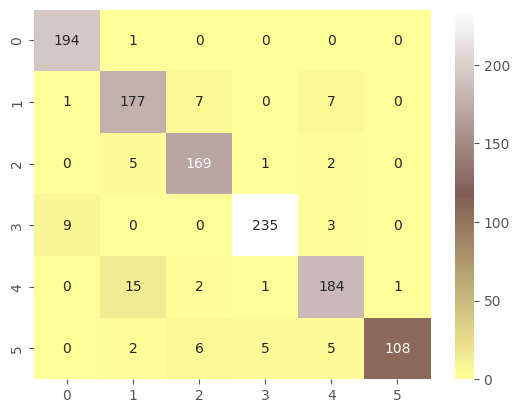

In [27]:
CM = confusion_matrix(trueClasses, predictedClasses)
sns.heatmap(CM, center = True,cmap='terrain',annot=True ,fmt='.5g')
plt.show()

In [28]:
ClassificationReport = classification_report(trueClasses, predictedClasses)
print('Classification Report is : \n', ClassificationReport )

Classification Report is : 
               precision    recall  f1-score   support

           0       0.95      0.99      0.97       195
           1       0.89      0.92      0.90       192
           2       0.92      0.95      0.94       177
           3       0.97      0.95      0.96       247
           4       0.92      0.91      0.91       203
           5       0.99      0.86      0.92       126

    accuracy                           0.94      1140
   macro avg       0.94      0.93      0.93      1140
weighted avg       0.94      0.94      0.94      1140



In [29]:
images = []
predictedClasses = []
trueClasses = []


class_labels = list(testGenerator.class_indices.keys())

for i in range(len(testGenerator)):
    img_batch, true_labels_batch = next(testGenerator)  # Get next batch
    true_class_idx = np.argmax(true_labels_batch[0])  # Get the true class index

    # Predict the class for the image
    prediction = Model.predict(img_batch)
    predicted_class_idx = np.argmax(prediction[0])  # Get the predicted class index

    # Convert the class indices to class labels
    predicted_class = class_labels[predicted_class_idx]
    true_class = class_labels[true_class_idx]

    images.append(np.squeeze(img_batch[0]))
    predictedClasses.append(predicted_class)
    trueClasses.append(true_class)

    if i >= 24:  # For example, only plot 24 images
        break

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


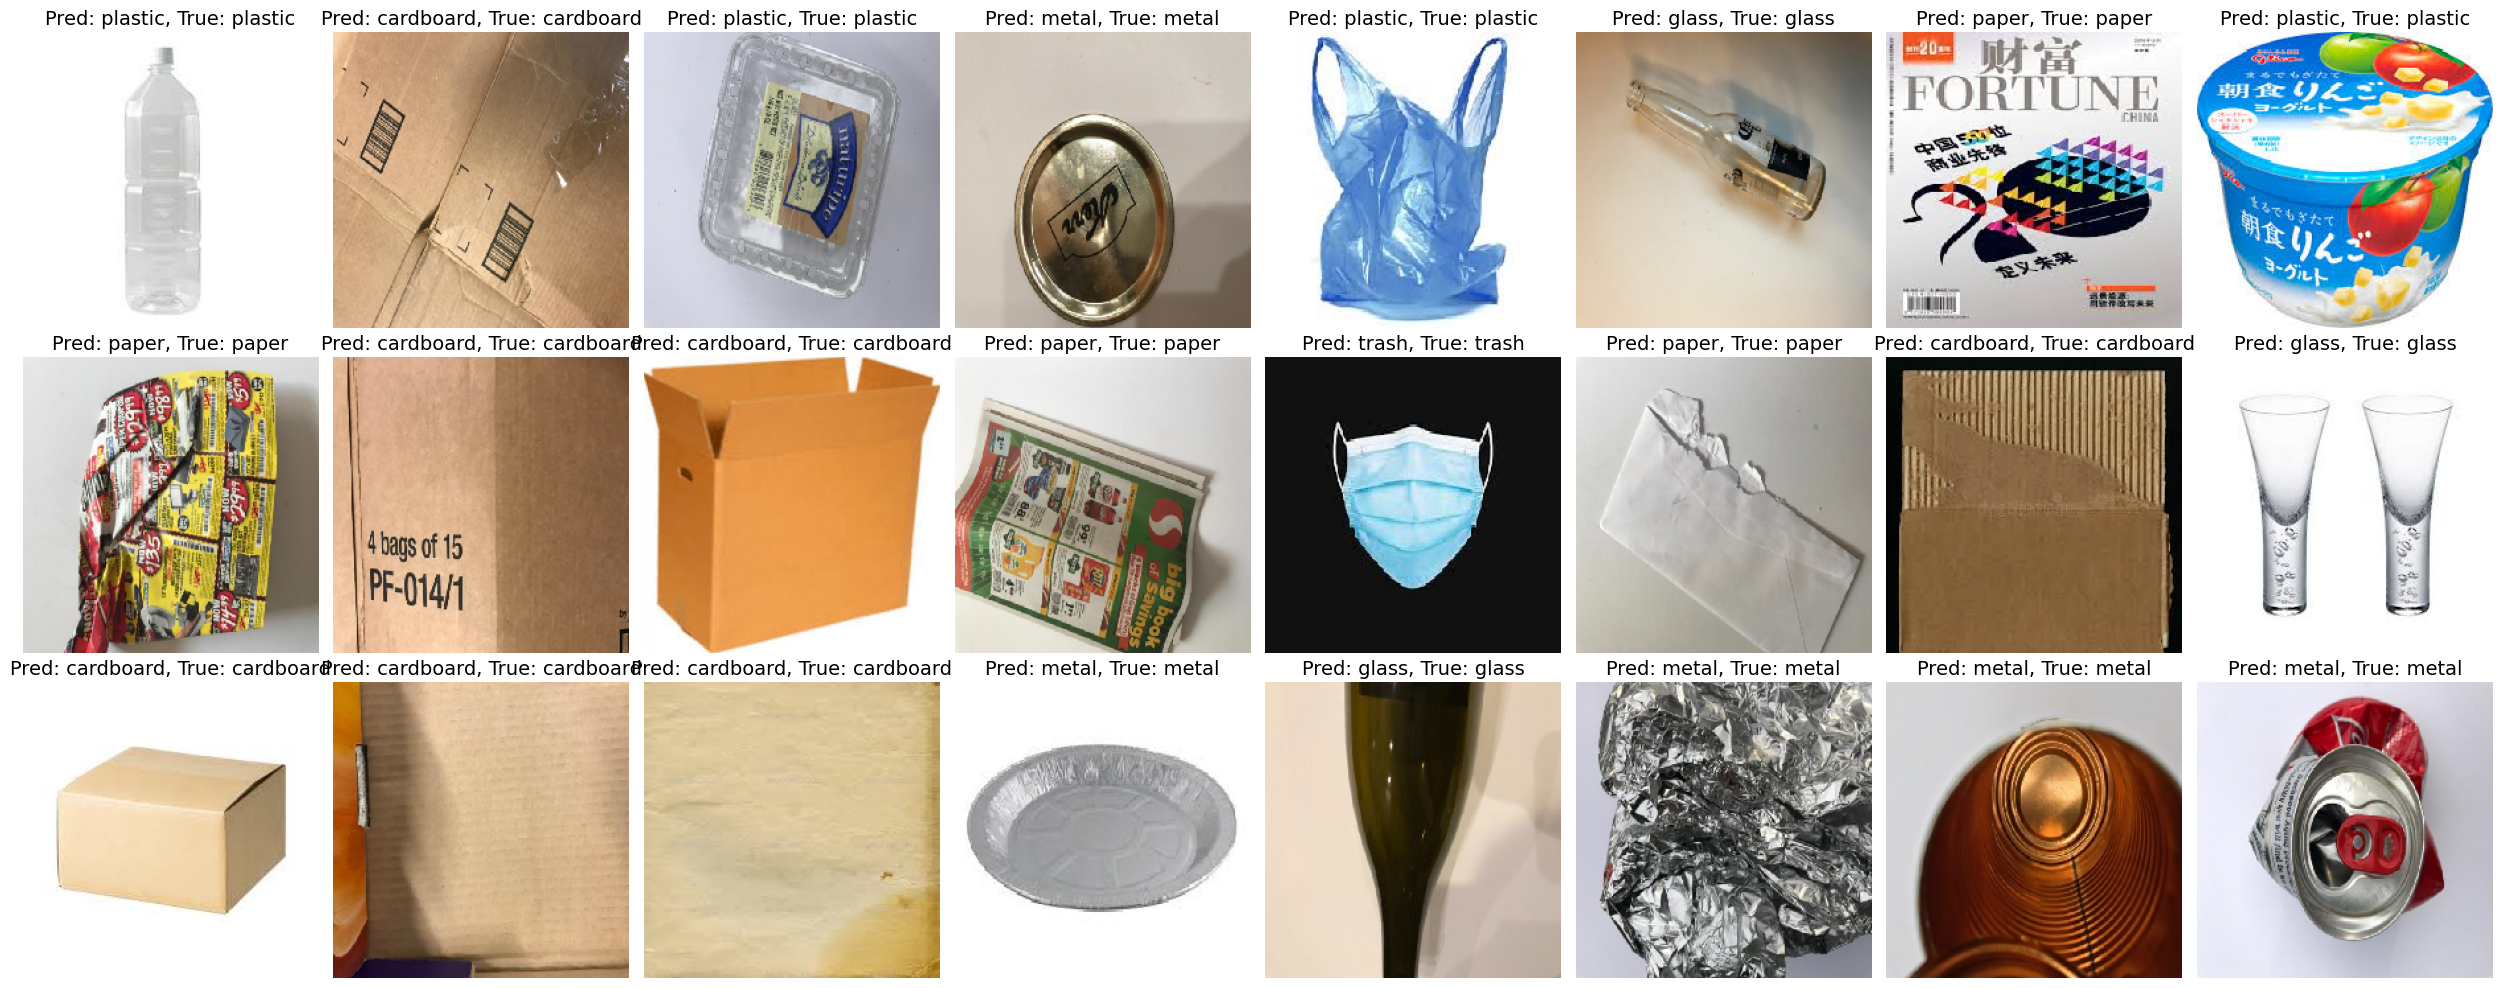

In [30]:
fig, axs = plt.subplots(3, 8, figsize=(25, 10))


axs = axs.flatten()

for ax,img , pred , true in zip(axs , images , predictedClasses , trueClasses):
    ax.imshow(img)
    ax.set_title(f"Pred: {pred}, True: {true}" ,fontsize=14)
    ax.axis('off')

plt.tight_layout()
plt.show()